In [1]:

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [2]:

train_dir = r'C:\Users\nlpsw\Downloads\caries_detect\teeth_dataset\Trianing'
test_dir = r'C:\Users\nlpsw\Downloads\caries_detect\teeth_dataset\test'

In [3]:

train_caries_count = len(os.listdir(os.path.join(train_dir, 'caries')))
train_no_caries_count = len(os.listdir(os.path.join(train_dir, 'without_caries')))
test_caries_count = len(os.listdir(os.path.join(test_dir, 'caries')))
test_no_caries_count = len(os.listdir(os.path.join(test_dir, 'no-caries')))

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


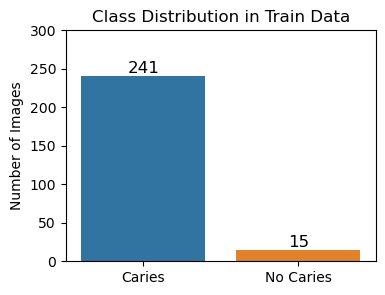

In [54]:

plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[train_caries_count, train_no_caries_count])
plt.title('Class Distribution in Train Data')
plt.ylabel('Number of Images')
plt.ylim(0, 300) 

for i, count in enumerate([train_caries_count, train_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


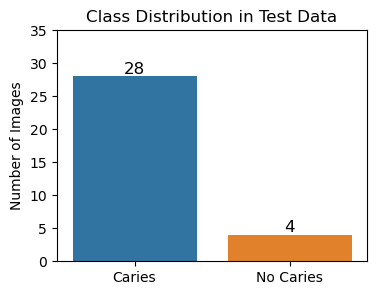

In [4]:

plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[test_caries_count, test_no_caries_count])
plt.title('Class Distribution in Test Data')
plt.ylabel('Number of Images')
plt.ylim(0, 35) 


for i, count in enumerate([test_caries_count, test_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

### Histograms of Pixel Intensities

(array([  4897.,   2781.,   3605.,   4224.,   5555.,   9007.,   9062.,
          9439.,   9165.,   9469.,  12733.,  11419.,  14220.,  16290.,
         16905.,  19370.,  22445.,  24671.,  24921.,  25370.,  31449.,
         29229.,  32509.,  32971.,  36617.,  40084.,  45245.,  49556.,
         49997.,  53074.,  75992.,  74529.,  75502.,  76270.,  71678.,
         72197.,  76222.,  89204., 102723.,  93287., 111569.,  99688.,
        101434.,  97775.,  89413.,  64605.,  58929.,  65541.,  58547.,
         46536.]),
 array([  0.        ,   5.0999999 ,  10.19999981,  15.30000019,
         20.39999962,  25.5       ,  30.60000038,  35.70000076,
         40.79999924,  45.90000153,  51.        ,  56.09999847,
         61.20000076,  66.30000305,  71.40000153,  76.5       ,
         81.59999847,  86.69999695,  91.80000305,  96.90000153,
        102.        , 107.09999847, 112.19999695, 117.30000305,
        122.40000153, 127.5       , 132.6000061 , 137.69999695,
        142.80000305, 147.8999939 , 

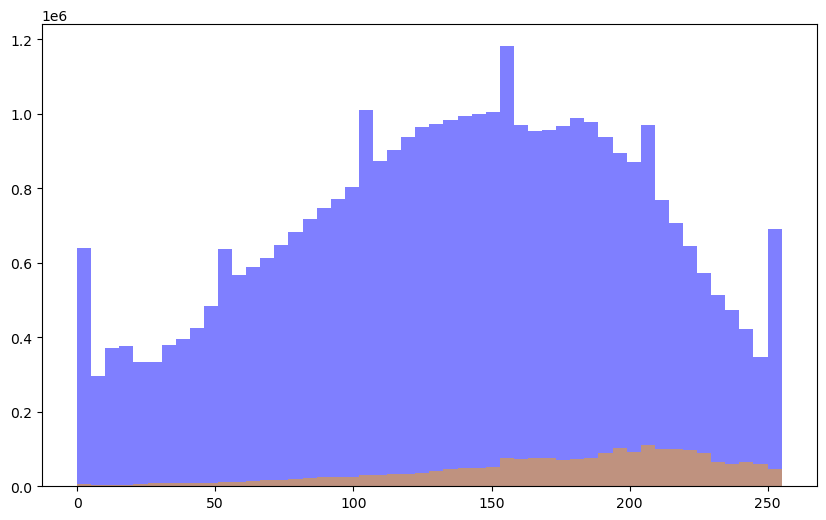

In [5]:

target_size = (224, 224)


caries_image_paths = [os.path.join(train_dir, 'caries', filename) for filename in os.listdir(os.path.join(train_dir, 'caries'))]
caries_images = []
for img_path in caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    caries_images.append(img_array)
caries_images = np.array(caries_images)

no_caries_image_paths = [os.path.join(train_dir, 'without_caries', filename) for filename in os.listdir(os.path.join(train_dir, 'without_caries'))]
no_caries_images = []
for img_path in no_caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    no_caries_images.append(img_array)
no_caries_images = np.array(no_caries_images)

plt.figure(figsize=(10, 6))
plt.hist(caries_images.flatten(), bins=50, color='blue', alpha=0.5, label='Caries')
plt.hist(no_caries_images.flatten(), bins=50, color='orange', alpha=0.5, label='No Caries')

## Displaying Sample Images from Each Class

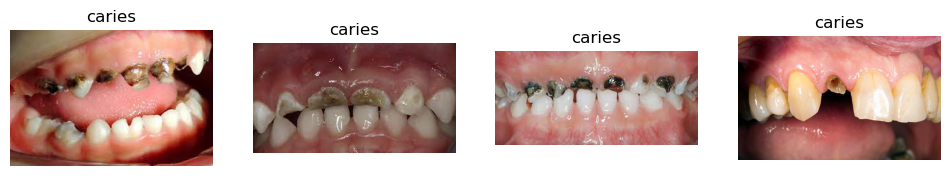

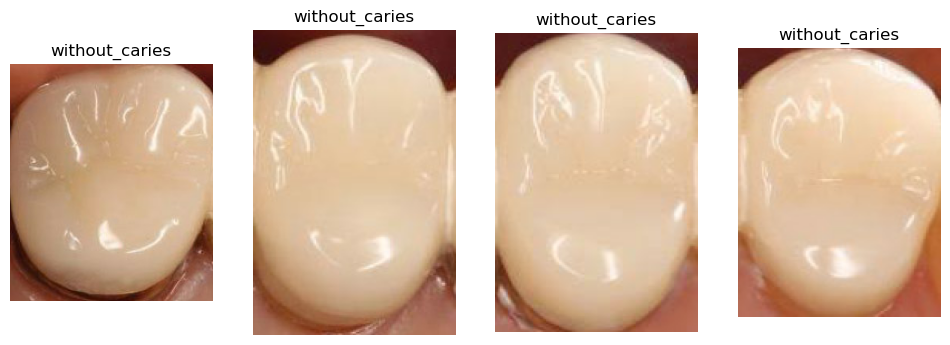

In [6]:
def display_samples(class_name, directory):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        img = Image.open(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_samples('caries', train_dir)
display_samples('without_caries', train_dir)

# Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


## Displaying Some Augmented Images

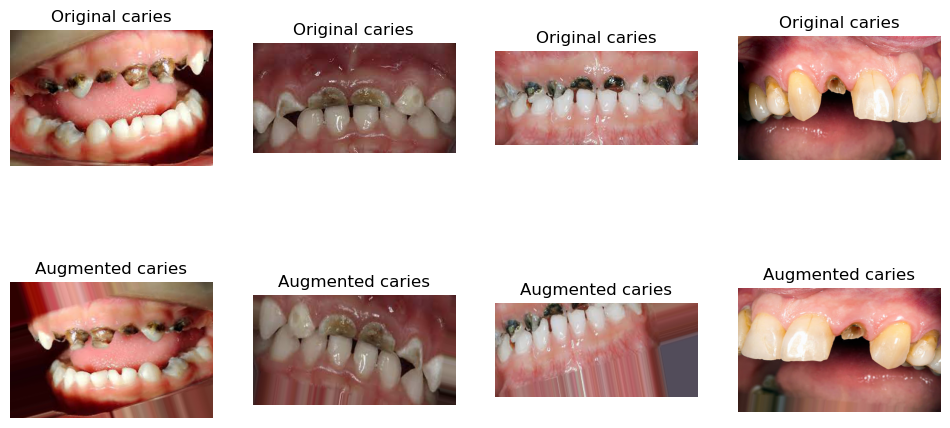

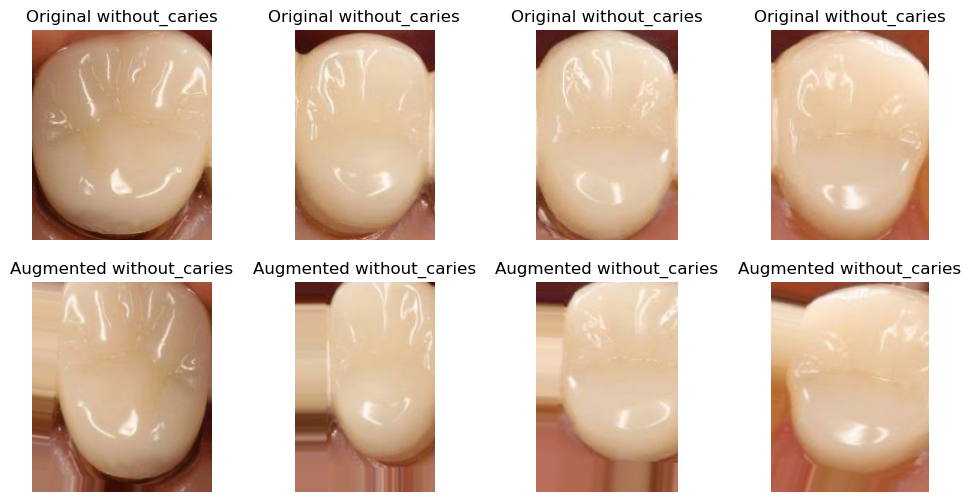

In [8]:
def display_augmented_images(class_name, directory, generator):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        original_image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        original_img = Image.open(original_image_path)
        
        original_array = np.array(original_img)
       
        augmented_array = generator.random_transform(original_array)
        
        augmented_img = Image.fromarray(augmented_array)
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(original_img)
        plt.title(f'Original {class_name}')
        plt.axis('off')
        
        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented_img)
        plt.title(f'Augmented {class_name}')
        plt.axis('off')
    
    plt.show()

# Display augmented images for 'caries' class
display_augmented_images('caries', train_dir, train_datagen)

# Display augmented images for 'no_caries' class
display_augmented_images('without_caries', train_dir, train_datagen)

## Modeling

In [9]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

D:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/10


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 783ms/step - accuracy: 0.7718 - loss: 11.9212 - val_accuracy: 0.8750 - val_loss: 6.7847
Epoch 2/10


D:\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

In [12]:

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8750 - loss: 6.7847
Test accuracy: 0.875


In [42]:

predictions = model.predict(test_generator)
y_pred = np.round(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [15]:
import warnings
from sklearn.metrics import confusion_matrix, classification_report, UndefinedMetricWarning
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Assuming you already have y_pred and test_generator
# y_pred should be the predicted classes
# test_generator.classes should be the true classes

# Compute confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)


ImportError: cannot import name 'UndefinedMetricWarning' from 'sklearn.metrics' (D:\anaconda\Lib\site-packages\sklearn\metrics\__init__.py)

Text(0.5, 1.0, 'Training and Validation Accuracy')

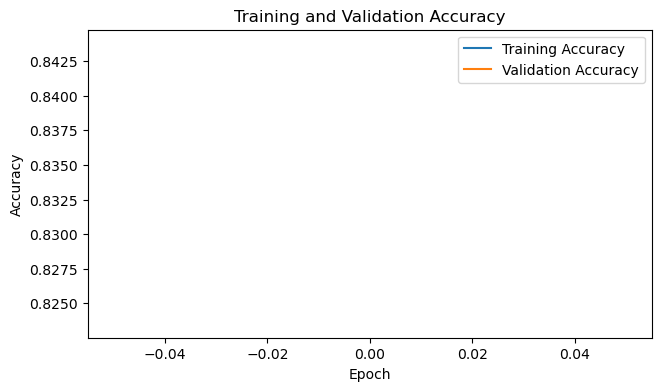

In [31]:

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

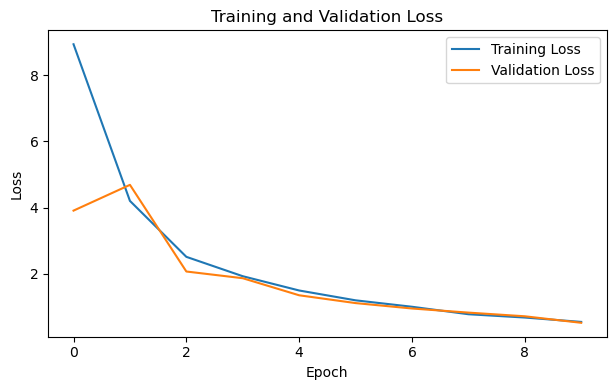

In [16]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

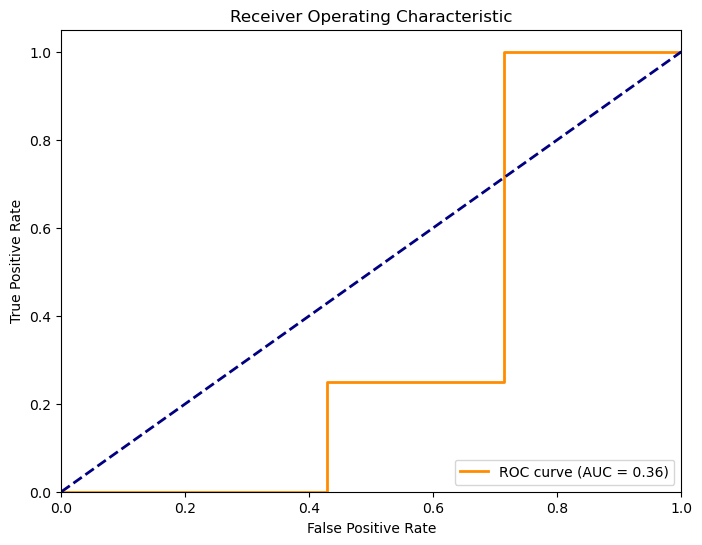

In [17]:

fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Predicting Some Images

1/1 [==============================] - 0s 354ms/step


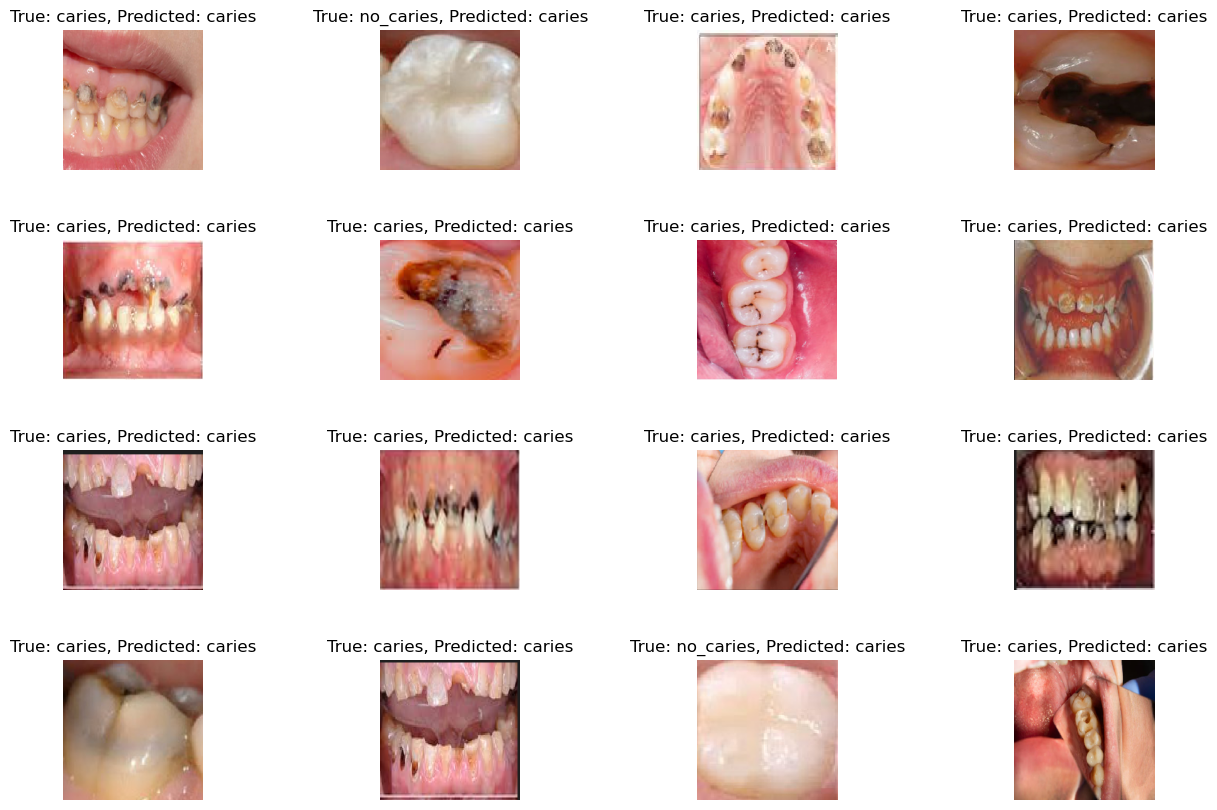

In [18]:

num_images_to_predict = 16  

test_images, true_labels = next(test_generator)


predicted_labels = model.predict(test_images)


predicted_labels = np.round(predicted_labels)


class_names = ['caries', 'no_caries']

num_rows = 4
num_cols = (num_images_to_predict + num_rows - 1) // num_rows

plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()

In [ ]:
print(